In [1]:
import numpy as np
import os
import kaggle_data_manager as kdm
import segnet_model
import kaggle_data_generator as kdg
import utils
from keras.callbacks import TensorBoard
from utils import init_logging, log_debug, log_info, log_warning, log_critical, log_exception

# os.environ["CUDA_VISIBLE_DEVICES"]="-1"

%matplotlib inline

init_logging("image_segmentation.ini")

## 1. Build the model, print summary and save the model.
log_info("Current working directory is %s" %os.getcwd())

segnet_instance = segnet_model.SegnetModel("image_segmentation.ini")
model = segnet_instance.load_model("optimizers.Adam(lr=0.0001)", loss_type = segnet_model.LossType.CROSS_ENTROPY_DICE_LOSS)
if (model == None):
    log_info("Failed to find saved model data. Building model for training.")
    model = segnet_instance.build("optimizers.Adam(lr=0.0001)", loss_type = segnet_model.LossType.CROSS_ENTROPY_DICE_LOSS)

log_info("\n*** Model summary is as below\n")
log_info(model.summary())


Using TensorFlow backend.
INFO:root:Current working directory is /home/ubuntu/illinois/deeplearning/deep_learning_project/src
INFO:root:Total number of gpus 4
INFO:root:Not loading existing weights as model is being retrained.
INFO:root:Failed to find saved model data. Building model for training.


Logging level is  20
Logging level is  20


INFO:root:
*** Model summary is as below

INFO:root:None


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 512, 512, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 512, 512, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 512, 512, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_4 (

INFO:root:Config values read from ini file are
INFO:root:Data path is /home/ubuntu/illinois/data. Image Width 512, Image Height 512
INFO:root:Done printing config values
INFO:root:Training masks path is /home/ubuntu/illinois/data/train_masks.csv


Logging level is  20


INFO:root:Max training examples to use 5088
INFO:root:Image ids length 5088
INFO:root:Image path is /home/ubuntu/illinois/data/train 
INFO:root:total images are 5088 
INFO:root:Returning training images
INFO:root:Total training images is 5088
INFO:root:Image path is /home/ubuntu/illinois/data/train_masks 
INFO:root:total images are 5088 
INFO:root:Returning training images
INFO:root:Total training images in list is 5088
INFO:root:Here in plot_image()
INFO:root:00087a6bd4dc_01


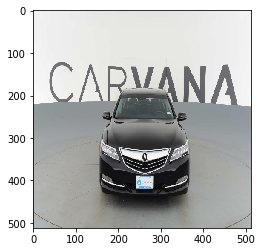

INFO:root:Here in plot_image_helper()


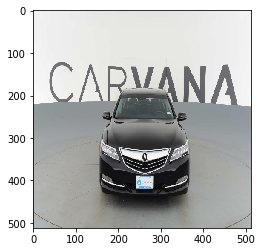

INFO:root:Here in plot_image()
INFO:root:00087a6bd4dc_01


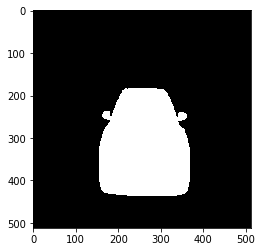

In [2]:
## 2. Initialize the kaggle data manager class. This object loads the training data which includes the training and mask
##    images and sets up the Keras ImageDataGenerator instances which will serve the model with training and validation
##    data
data_manager = kdm.KaggleDataManager("image_segmentation.ini")


Instructions for updating:
Use `tf.global_variables_initializer` instead.


Instructions for updating:
Use `tf.global_variables_initializer` instead.
INFO:root:Log file path is carvana/training_logs
INFO:root:Model checkpoints path is carvana/checkpoints
INFO:root:Batch size is 8
INFO:root:Epochs is 30
INFO:root:Steps per epoch is 508
INFO:root:Validation steps is 127
INFO:root:In get_next_batch_validate()
INFO:root:In get_next_batch_train()


Epoch 1/30
508/508 [==============================] - 779s 2s/step - loss: 0.2575 - dice_coef: 0.8441 - val_loss: 0.2599 - val_dice_coef: 0.8758

Epoch 00001: val_loss improved from inf to 0.25987, saving model to carvana/checkpoints
Epoch 2/30
508/508 [==============================] - 760s 1s/step - loss: 0.1132 - dice_coef: 0.9295 - val_loss: 0.0872 - val_dice_coef: 0.9458

Epoch 00002: val_loss improved from 0.25987 to 0.08723, saving model to carvana/checkpoints
Epoch 3/30
508/508 [==============================] - 755s 1s/step - loss: 0.0674 - dice_coef: 0.9597 - val_loss: 0.0663 - val_dice_coef: 0.9648

Epoch 00003: val_loss improved from 0.08723 to 0.06632, saving model to carvana/checkpoints
Epoch 4/30
508/508 [==============================] - 751s 1s/step - loss: 0.0460 - dice_coef: 0.9729 - val_loss: 0.0495 - val_dice_coef: 0.9717

Epoch 00004: val_loss improved from 0.06632 to 0.04946, saving model to carvana/checkpoints
Epoch 5/30
508/508 [==============================] 

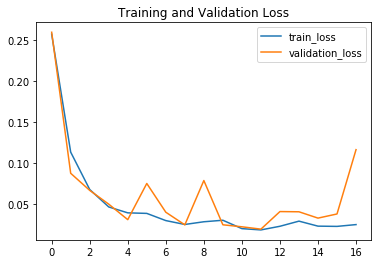

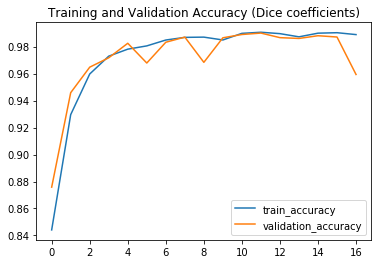

INFO:root:Done training model
INFO:root:
Saving model
INFO:root:
 Saved model structure to model file carvana/car_image_segmentation_nn_augmented.json and weights to carvana/cnn_image_segmentation_nn_augmented.h5


In [3]:
from time import time
from keras.callbacks import EarlyStopping, ModelCheckpoint
import keras
import tensorflow as tf

import keras
gpu_options = tf.GPUOptions(allow_growth=True)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
keras.backend.tensorflow_backend.set_session(sess)
keras.backend.get_session().run(tf.initialize_all_variables())

## 3. Model training.

logs_path = utils.get_config_value("image_segmentation.ini", "General", "logFilePath")
log_info("Log file path is %s" %logs_path)

checkpoints_path = utils.get_config_value("image_segmentation.ini", "General", "modelCheckpointsPath")
log_info("Model checkpoints path is %s" %checkpoints_path)

batch_size = int(utils.get_config_value("image_segmentation.ini", "General", "BatchSize"))
log_info("Batch size is %d" %batch_size)

epochs = int(utils.get_config_value("image_segmentation.ini", "General", "Epochs"))
log_info("Epochs is %d" %epochs)

# https://fizzylogic.nl/2017/05/08/monitor-progress-of-your-keras-based-neural-network-using-tensorboard/
tensorboard = TensorBoard(log_dir=logs_path + "/{}".format(time()))

# https://chrisalbon.com/deep_learning/keras/neural_network_early_stopping/
callbacks = [EarlyStopping(monitor='val_loss', verbose = 1, patience=5),
             ModelCheckpoint(filepath=checkpoints_path, monitor='val_loss', verbose = 1, save_best_only=True,
                            save_weights_only = True),
            tensorboard]

steps_per_epoch = data_manager.get_number_of_training_records() // batch_size
validation_steps = data_manager.get_number_of_validation_records() // batch_size

data_manager.init_generator(kdg.BatchType.TRAIN_DATA)
data_manager.init_generator(kdg.BatchType.VALIDATION_DATA)

log_info("Steps per epoch is %d" %steps_per_epoch)
log_info("Validation steps is %d" %validation_steps)

history = model.fit_generator(
        data_manager.get_next_batch_train(batch_size), 
        steps_per_epoch = steps_per_epoch, 
        epochs = epochs,
        callbacks = callbacks,
        verbose = 1,
        validation_data = data_manager.get_next_batch_validate(batch_size),
        validation_steps = validation_steps)

utils.plot_training_graphs(history, "Training and Validation Loss", "loss", "val_loss", "train_loss", "validation_loss")
utils.plot_training_graphs(history, "Training and Validation Accuracy (Dice coefficients)", "dice_coef", "val_dice_coef", "train_accuracy", "validation_accuracy")

log_info("Done training model")
log_info("\nSaving model")
segnet_instance.save()
